# 订阅号系统

此项目实现了一个订阅号系统，功能对照微信的订阅号实现。

## 罗列业务需求

本次实习的目标业务是微信公众号的功能，其核心主要有以下几点：
1. **发布推文**：公众号可以发布推文，订阅公众号的用户会得到提醒
2. **评论推文**：用户可以在推文下方的评论处发表评论，点赞推文，也可以回复其他用户的评论（类似论坛）
3. **管理公众号**：公众号由多个用户管理，他们可以增删公众号中的推文以及推文中的评论

## 数据库设计

设计如下 4 种强实体，并确定其属性
+ 用户（<u>微信号</u>，昵称，性别，手机号）
+ 公众号（<u>公众号ID</u>，名称，拥有者微信号）
+ 推文（<u>推文ID</u>，标题，内容，发布公众号，发布时间）
+ 主题（<u>主题ID</u>，名称，简介）

评论是依赖于推文的弱实体，其设计如下
+ 评论（<u>推文ID，评论ID</u>，内容，发送时间，发送者微信号，主评论ID，回复的评论ID）

我们用主评论来表示回复评论与评论的关系，在微信的展示中，回复评论都会处于某条评论之下，将这条评论称为主评论，一条主评论的主评论ID属性为 null。回复评论的目标可能是主评论，也可能是一条回复评论，也可能没有目标（用null表示）

接下来列举实体间存在的联系：
+ **订阅**：用户订阅公众号，多对多
+ **管理**：用户管理公众号，多对多
+ **关注**：用户关注主题，多对多
+ **发布**：公众号发布推文，一对多
+ **归属**：推文属于某个主题，多对多
+ **属于**：评论属于某个推文，一对多
+ **发送**：用户发送评论，多对多，不过每一条评论都只能有一个发送者
+ **根评论**：评论属于某个主评论，一对多，对于作为主评论的评论，其主评论为 null
+ **回复**：回复评论属于某个评论下，一对多
+ **点赞评论**：用户点赞推文，多对多
+ **点赞推文**：用户点赞推文，多对多

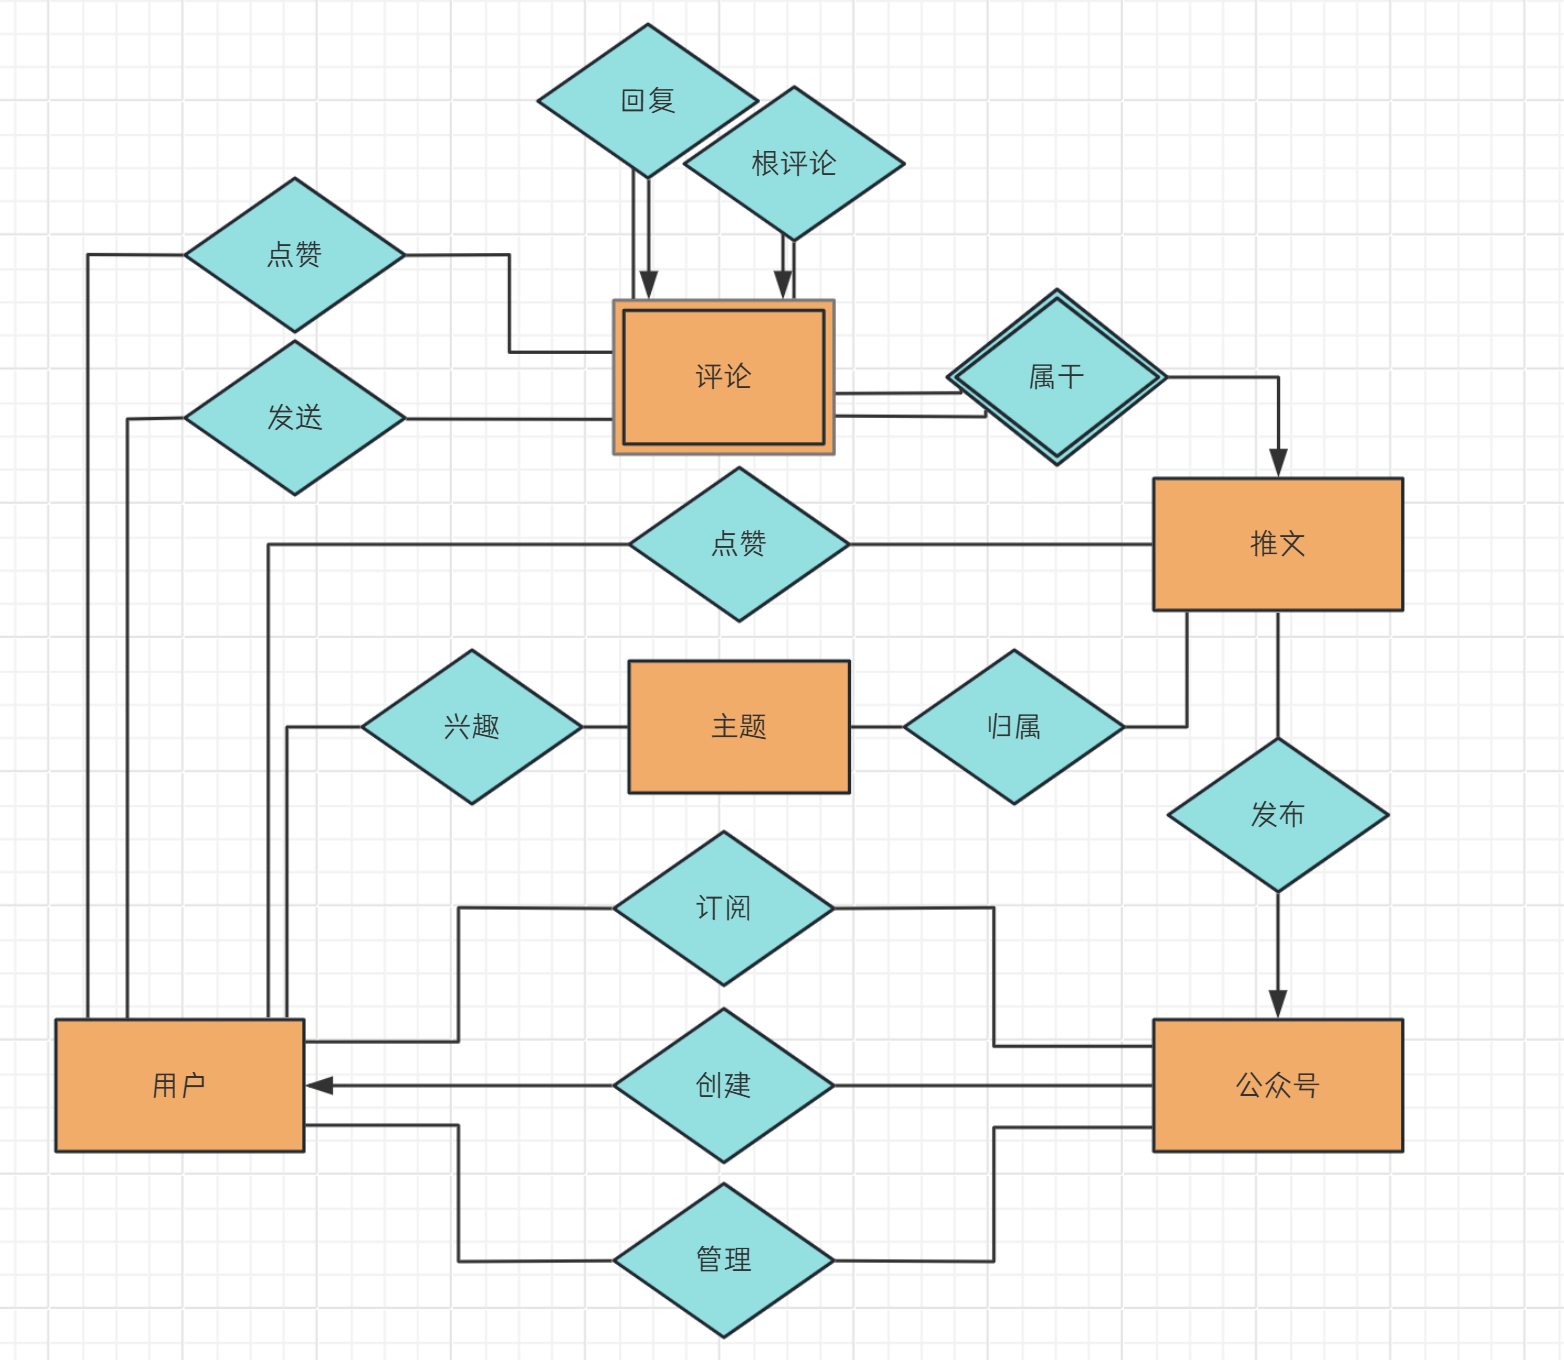

## 关系表设计

根据ER图，我们设计如下关系表：
+ 用户表（users）：UID, username, password, created_at
+ 公众号表（channels）：NID, name, created_by, created_at, description
+ 推文表（posts）：PID, title, content, created_at, from_channel
+ 评论表（comments）：CID, PID, from_user, to_comment, master_comment, content
+ 主题表（themes）：TID, type, description
+ 订阅表（subscribe）：UID, NID
+ 管理表（manage_channel）：UID, NID
+ 点赞推文表（like_post）：UID, PID
+ 点赞评论表（like_comment）：UID, CID, PID
+ 关注主题表（interested_in_theme）：UID, TID
+ 归属主题表（belong_to_theme）：PID, TID

## 创建数据库

按照create_db.py中的内容进行操作

In [1]:
import pymysql

# 数据库配置在 app.py，你可以更改为自己本地的数据库
from app import db_config

# 创建数据库并插入测试数据
def create_db():
    # 创建数据库连接
    connection = pymysql.connect(**db_config)

    try:
        with connection.cursor() as cursor:
            # clear database
            cursor.execute(
                """
            DROP TABLE IF EXISTS like_comment, like_post, belong_to_theme, interested_in_theme, manage_channel, subscribe, themes, comments, posts, channels, users;
            """
            )

            # create tables
            cursor.execute(
                """
            CREATE TABLE users (
                uid INT AUTO_INCREMENT PRIMARY KEY,
                username VARCHAR(50) UNIQUE NOT NULL,
                password VARCHAR(300) NOT NULL,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            );
            """
            )

            cursor.execute(
                """
            CREATE TABLE channels (
                nid INT AUTO_INCREMENT PRIMARY KEY,
                name VARCHAR(50) UNIQUE NOT NULL,
                created_by INT NOT NULL,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                FOREIGN KEY (created_by) REFERENCES users(uid)
            );
            """
            )

            cursor.execute(
                """
            CREATE TABLE posts (
                pid INT AUTO_INCREMENT PRIMARY KEY,
                title VARCHAR(50) UNIQUE NOT NULL,
                from_channel INT NOT NULL,
                content TEXT NOT NULL,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                FOREIGN KEY (from_channel) REFERENCES channels(nid)
            );
            """
            )

            cursor.execute(
                """
            CREATE TABLE comments (
                cid INT,
                pid INT,
                from_user INT,
                to_comment INT,
                master_comment INT,
                content TEXT NOT NULL,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                FOREIGN KEY (pid) REFERENCES posts(pid),
                FOREIGN KEY (from_user) REFERENCES users(uid),
                FOREIGN KEY (to_comment, pid) REFERENCES comments(cid, pid),
                FOREIGN KEY (master_comment, pid) REFERENCES comments(cid, pid),
                PRIMARY KEY (cid, pid)
            );
            """
            )

            cursor.execute(
                """
            CREATE TABLE themes (
                tid INT AUTO_INCREMENT PRIMARY KEY,
                type VARCHAR(50) UNIQUE NOT NULL,
                description TEXT
            );
            """
            )

            cursor.execute(
                """
            CREATE TABLE subscribe (
                uid INT NOT NULL,
                nid INT NOT NULL,
                FOREIGN KEY (uid) REFERENCES users(uid),
                FOREIGN KEY (nid) REFERENCES channels(nid)
            );
            """
            )

            cursor.execute(
                """
            CREATE TABLE manage_channel (
                uid INT NOT NULL,
                nid INT NOT NULL,
                FOREIGN KEY (uid) REFERENCES users(uid),
                FOREIGN KEY (nid) REFERENCES channels(nid)
            );
            """
            )

            cursor.execute(
                """
            CREATE TABLE like_post (
                uid INT NOT NULL,
                pid INT NOT NULL,
                FOREIGN KEY (uid) REFERENCES users(uid),
                FOREIGN KEY (pid) REFERENCES posts(pid)
            );
            """
            )

            cursor.execute(
                """
            CREATE TABLE like_comment (
                uid INT NOT NULL,
                cid INT NOT NULL,
                pid INT NOT NULL,
                FOREIGN KEY (uid) REFERENCES users(uid),
                FOREIGN KEY (cid, pid) REFERENCES comments(cid, pid)
            );
            """
            )

            cursor.execute(
                """
            CREATE TABLE interested_in_theme (
                uid INT NOT NULL,
                tid INT NOT NULL,
                FOREIGN KEY (uid) REFERENCES users(uid),
                FOREIGN KEY (tid) REFERENCES themes(tid)
            );
            """
            )

            cursor.execute(
                """
            CREATE TABLE belong_to_theme (
                pid INT NOT NULL,
                tid INT NOT NULL,
                FOREIGN KEY (pid) REFERENCES posts(pid),
                FOREIGN KEY (tid) REFERENCES themes(tid)
            );
            """
            )

            # insert values
            cursor.execute(
                """
            -- 插入用户数据
            INSERT INTO users (username, password) VALUES 
            ('alice', 'alice123'),
            ('bob', 'bob123'),
            ('charlie', 'charlie123'),
            ('david', 'david123'),
            ('eve', 'eve123');
            """
            )

            cursor.execute(
                """
            -- 插入公众号数据
            INSERT INTO channels (name, created_by) VALUES 
            ('TechNews', 1),
            ('GadgetReviews', 2),
            ('ScienceDaily', 3),
            ('HealthTips', 4),
            ('TravelBlog', 5);
            """
            )

            cursor.execute(
                """
            -- 插入主题数据
            INSERT INTO themes (type, description) VALUES 
            ('Technology', 'All about technology and innovation'),
            ('Science', 'Discoveries and scientific research'),
            ('Health', 'Health tips and wellness'),
            ('Travel', 'Travel destinations and experiences'),
            ('Gadgets', 'Latest gadgets and reviews');
            """
            )

            cursor.execute(
                """
            -- 插入用户关注的公众号关系
            INSERT INTO subscribe (uid, nid) VALUES 
            (1, 1), (1, 2), (1, 3),  -- Alice关注TechNews, GadgetReviews, ScienceDaily
            (2, 1), (2, 4),          -- Bob关注TechNews, HealthTips
            (3, 2), (3, 5),          -- Charlie关注GadgetReviews, TravelBlog
            (4, 3), (4, 4), (4, 5),  -- David关注ScienceDaily, HealthTips, TravelBlog
            (5, 1), (5, 2), (5, 3), (5, 4), (5, 5); -- Eve关注所有公众号
            """
            )

            cursor.execute(
                """
            -- 插入用户管理的公众号关系
            INSERT INTO manage_channel (uid, nid) VALUES 
            (1, 1),  -- Alice管理TechNews
            (2, 2),  -- Bob管理GadgetReviews
            (3, 3),  -- Charlie管理ScienceDaily
            (4, 4),  -- David管理HealthTips
            (5, 5);  -- Eve管理TravelBlog
            """
            )

            cursor.execute(
                """
            -- 插入推文数据（每个公众号多篇推文）
            INSERT INTO posts (title, from_channel, content) VALUES 
            ('AI Breakthroughs', 1, 'Latest advancements in AI technology'),
            ('Smartphone Comparison', 2, 'Comparing the latest smartphones'),
            ('Quantum Computing', 1, 'Understanding quantum computing basics'),
            ('Wearable Tech', 2, 'Review of the newest wearable devices'),
            ('Space Exploration', 3, 'Recent developments in space research'),
            ('Nutrition Tips', 4, 'Healthy eating habits for better wellness'),
            ('Travel Destinations', 5, 'Top travel destinations for 2023'),
            ('Mental Health', 4, 'Tips for maintaining mental health'),
            ('Vacation Planning', 5, 'How to plan the perfect vacation'),
            ('Future of Work', 1, 'How technology is reshaping workplaces');
            """
            )

            cursor.execute(
                """
            -- 插入推文所属的主题关系
            INSERT INTO belong_to_theme (pid, tid) VALUES 
            (1, 1), (1, 5),  -- AI Breakthroughs属于Technology和Gadgets
            (2, 5),          -- Smartphone Comparison属于Gadgets
            (3, 1),          -- Quantum Computing属于Technology
            (4, 5),          -- Wearable Tech属于Gadgets
            (5, 2),          -- Space Exploration属于Science
            (6, 3),          -- Nutrition Tips属于Health
            (7, 4),          -- Travel Destinations属于Travel
            (8, 3),          -- Mental Health属于Health
            (9, 4),          -- Vacation Planning属于Travel
            (10, 1);         -- Future of Work属于Technology

            -- 插入评论数据（复杂结构）"""
            )

            cursor.execute(
                """
            -- 对于推文1的评论
            INSERT INTO comments (cid, pid, from_user, to_comment, master_comment, content) VALUES 
            (0, 1, 2, NULL, NULL, 'Great insights on AI!'),  -- 根评论
            (1, 1, 3, 0, 0, 'I agree, especially about neural networks.'),  -- 回复根评论
            (2, 1, 5, 0, 0, 'What about ethical considerations?'),  -- 回复根评论
            (3, 1, 1, 1, 0, 'Thanks! I think ethics is crucial too.'),  -- 回复评论1
            (4, 1, 4, 2, 0, 'That''s a good point. We need more discussion on AI ethics.');  -- 回复评论2
            """
            )

            cursor.execute(
                """
            -- 对于推文2的评论
            INSERT INTO comments (cid, pid, from_user, to_comment, master_comment, content) VALUES 
            (0, 2, 1, NULL, NULL, 'Which smartphone do you recommend?'),  -- 根评论
            (1, 2, 3, 0, 0, 'I prefer the newer model for battery life.'),  -- 回复根评论
            (2, 2, 5, 0, 0, 'Price is also a factor for me.'),  -- 回复根评论
            (3, 2, 2, 1, 0, 'Battery life is important, but so is camera quality.'),  -- 回复评论1
            (4, 2, 4, 2, 0, 'Agreed. Value for money is key.');  -- 回复评论2
            """
            )

            cursor.execute(
                """
            -- 对于推文5的评论
            INSERT INTO comments (cid, pid, from_user, to_comment, master_comment, content) VALUES 
            (0, 5, 4, NULL, NULL, 'Fascinating developments in space!'),  -- 根评论
            (1, 5, 5, 0, 0, 'I hope we see more missions soon.'),  -- 回复根评论
            (2, 5, 2, 0, 0, 'What about Mars colonization?'),  -- 回复根评论
            (3, 5, 3, 1, 0, 'Me too! Space exploration inspires innovation.'),  -- 回复评论1
            (4, 5, 1, 2, 0, 'That''s the next big frontier. Very exciting!');  -- 回复评论2
            """
            )

            cursor.execute(
                """
            -- 插入用户点赞推文的关系
            INSERT INTO like_post (uid, pid) VALUES 
            (1, 1), (1, 3), (1, 5), (1, 7),  -- Alice点赞
            (2, 2), (2, 4), (2, 6),          -- Bob点赞
            (3, 1), (3, 2), (3, 9),          -- Charlie点赞
            (4, 5), (4, 6), (4, 8),          -- David点赞
            (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10);  -- Eve点赞所有推文
            """
            )

            cursor.execute(
                """
            -- 插入用户点赞评论的关系
            INSERT INTO like_comment (uid, cid, pid) VALUES 
            (1, 0, 1), (1, 3, 1),  -- Alice点赞推文1的评论0和3
            (2, 1, 2), (2, 4, 2),  -- Bob点赞推文2的评论1和4
            (3, 0, 5), (3, 2, 5),  -- Charlie点赞推文5的评论0和2
            (4, 4, 5),             -- David点赞推文5的评论4
            (5, 0, 1), (5, 1, 1), (5, 2, 1), (5, 3, 1), (5, 4, 1),  -- Eve点赞推文1的所有评论
            (5, 0, 2), (5, 1, 2), (5, 2, 2), (5, 3, 2), (5, 4, 2),  -- Eve点赞推文2的所有评论
            (5, 0, 5), (5, 1, 5), (5, 2, 5), (5, 3, 5), (5, 4, 5);  -- Eve点赞推文5的所有评论
            """
            )

            cursor.execute(
                """
            -- 插入用户感兴趣的主题关系
            INSERT INTO interested_in_theme (uid, tid) VALUES 
            (1, 1), (1, 2), (1, 5),  -- Alice对Technology, Science, Gadgets感兴趣
            (2, 5), (2, 3),          -- Bob对Gadgets, Health感兴趣
            (3, 4), (3, 5),          -- Charlie对Travel, Gadgets感兴趣
            (4, 2), (4, 3), (4, 4),  -- David对Science, Health, Travel感兴趣
            (5, 1), (5, 2), (5, 3), (5, 4), (5, 5);  -- Eve对所有主题感兴趣
            """
            )

        connection.commit()
        print("创建数据库成功！")
    except:
        print("创建数据库失败！")
    finally:
        connection.close()



create_db()

创建数据库成功！


## 数据库操作

TODO: 列出若干项业务功能（包含增删查改），给出对应的SQL语句。

In [2]:
connection = pymysql.connect(**db_config)
if connection.open:
    print("数据库连接成功！")

数据库连接成功！


In [3]:
# 获取pid为1的文章下的所有评论，并列出全部信息
import json
pid = 1

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    # 获取评论点赞者
    def get_comment_likers(cid):
        cursor.execute(
            """
            WITH likers AS (SELECT * FROM like_comment WHERE like_comment.pid = %s)
            SELECT u.username
            FROM likers AS l
            JOIN users AS u ON l.uid = u.uid
            WHERE l.cid = %s
        """,
            (pid, cid),
        )
        return [row["username"] for row in cursor.fetchall()]

    # 获取评论详细信息
    def get_comments(parent_cid=None):
        base_query = """
            SELECT c.*, u.username, 
            ru.username AS reply_to_user, rc.content AS reply_to_content
            FROM comments c
            LEFT JOIN users u ON c.from_user = u.uid
            LEFT JOIN comments rc ON c.to_comment = rc.cid AND c.pid = rc.pid
            LEFT JOIN users ru ON rc.from_user = ru.uid
            WHERE c.pid = %s
        """
        params = [pid]

        if parent_cid is None:
            base_query += " AND c.master_comment IS NULL"
        else:
            base_query += " AND c.master_comment = %s"
            params.append(parent_cid)

        cursor.execute(base_query, tuple(params))

        comments = []
        for comment in cursor.fetchall():
            comment_dict = {
                "cid": comment["cid"],
                "username": comment["username"],
                "content": comment["content"],
                "reply_to": (
                    {"user": comment['reply_to_user'], "content": comment['reply_to_content']} if comment['reply_to_user'] else None
                ),
                "replies": get_comments(comment["cid"]) if parent_cid is None else None,
                "likers": get_comment_likers(comment["cid"]),
            }
            comments.append(comment_dict)
        return comments

    comments_tree = get_comments()
    json_data = json.dumps(comments_tree)
    print(json_data)

[{"cid": 0, "username": "bob", "content": "Great insights on AI!", "reply_to": null, "replies": [{"cid": 1, "username": "charlie", "content": "I agree, especially about neural networks.", "reply_to": {"user": "bob", "content": "Great insights on AI!"}, "replies": null, "likers": ["eve"]}, {"cid": 2, "username": "eve", "content": "What about ethical considerations?", "reply_to": {"user": "bob", "content": "Great insights on AI!"}, "replies": null, "likers": ["eve"]}, {"cid": 3, "username": "alice", "content": "Thanks! I think ethics is crucial too.", "reply_to": {"user": "charlie", "content": "I agree, especially about neural networks."}, "replies": null, "likers": ["alice", "eve"]}, {"cid": 4, "username": "david", "content": "That's a good point. We need more discussion on AI ethics.", "reply_to": {"user": "eve", "content": "What about ethical considerations?"}, "replies": null, "likers": ["eve"]}], "likers": ["alice", "eve"]}]


In [4]:
#注册

# 测试的用户名和注册密码信息
name = 'new_user_1'
password = '123'

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #判断是否已经注册过
    sql_has_registered = """
    SELECT users.uid
    FROM users
    WHERE users.username = %s
    """
    cursor.execute(sql_has_registered,(name),)
    
    result = cursor.fetchone()
    
    print(result)
    if result is None:
        # 注册新账号
        sql_register = """
        INSERT INTO users (username, password) 
        VALUES (%s, %s);
        """
        cursor.execute(sql_register,(name,password),)
        print(f'注册成功，用户名为 {name}')
    else:
        print(f'{name} 已经注册过')
    
    


None
注册成功，用户名为 new_user_1


In [5]:
#登录
name = 'new_user_1'
password = '123'

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #判断密码是否符合
    sql_login = """
    SELECT users.uid
    FROM users
    WHERE users.username = %s AND users.password = %s
    """
    cursor.execute(sql_login,(name,password),)
    
    result = cursor.fetchall()
    if len(result) == 0:
        print('用户名或密码错误')
    else:
        print('登录成功')


登录成功


In [6]:
#修改密码
name = 'new_user_1'
new_password = '1243'

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #判断密码是否符合
    sql_change_password = """
    UPDATE users
    SET users.password = %s
    WHERE users.username = %s;
    """
    cursor.execute(sql_change_password,(new_password,name),)
    
    #检测是否修改成功
    cursor.execute("""
                SELECT *
                FROM users
                WHERE users.username = %s
                """,(name))
    result = cursor.fetchall()
    for row in result:
        print(row)

{'uid': 6, 'username': 'new_user_1', 'password': '1243', 'created_at': datetime.datetime(2025, 4, 12, 19, 38, 43)}


In [7]:
# （当前用户）列出全部公众号-查

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    sql_list_all_channels = """
                    SELECT channels.name
                    FROM channels
                    """
    cursor.execute(sql_list_all_channels)
    result = cursor.fetchall()
    for row in result:
        print(row)

{'name': 'GadgetReviews'}
{'name': 'HealthTips'}
{'name': 'ScienceDaily'}
{'name': 'TechNews'}
{'name': 'TravelBlog'}


In [8]:
# 关注-增
user_name = 'new_user_1'
channel_name = 'ScienceDaily'

#要插入subscribe表的内容
user_id = None
channel_id = None

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #获取uid
    sql_get_user_id_from_username = """
    SELECT users.uid
    FROM users
    WHERE users.username = %s
    """
    cursor.execute(sql_get_user_id_from_username,(user_name),)
    result = cursor.fetchone()
    user_id = result['uid']
    
    #获取nid
    sql_get_channel_id_from_channel_name = """
    SELECT channels.nid
    FROM channels
    WHERE channels.name = %s
    """
    cursor.execute(sql_get_channel_id_from_channel_name,(channel_name))
    result = cursor.fetchone()
    channel_id = result['nid']
    
    #将获得的(uid,nid)插入subscribe表中,如果已经关注,忽略
    sql_has_already_subscribed = """
    SELECT *
    FROM subscribe AS s
    WHERE s.uid = %s AND s.nid = %s
    """
    cursor.execute(sql_has_already_subscribed,(user_id,channel_id))
    result = cursor.fetchall()
    if len(result) == 0:
        sql_subscribe = """
            INSERT INTO subscribe (uid, nid)
            VALUES(%s,%s)
        """
        cursor.execute(sql_subscribe,(user_id,channel_id))
    
    sql_debug = """
        SELECT *
        FROM subscribe AS s
        WHERE s.uid = %s AND s.nid = %s
    """
    cursor.execute(sql_debug,(user_id,channel_id))
    result = cursor.fetchall()
    for row in result:
        print(row)


{'uid': 6, 'nid': 3}


In [9]:
# 取消关注-删
user_name = 'new_user_1'
channel_name = 'ScienceDaily'

#要删除subscribe表的内容
user_id = None
channel_id = None

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #获取uid
    sql_get_user_id_from_username = """
    SELECT users.uid
    FROM users
    WHERE users.username = %s
    """
    cursor.execute(sql_get_user_id_from_username,(user_name))
    result = cursor.fetchone()
    user_id = result['uid']
    
    #获取nid
    sql_get_channel_id_from_channel_name = """
    SELECT channels.nid
    FROM channels
    WHERE channels.name = %s
    """
    cursor.execute(sql_get_channel_id_from_channel_name,(channel_name))
    result = cursor.fetchone()
    channel_id = result['nid']
    
    #将subscribe表中(uid,nid)删除
    sql_unsubscribe = """
        DELETE FROM subscribe
        WHERE subscribe.uid = %s AND subscribe.nid = %s
    """
    cursor.execute(sql_unsubscribe,(user_id,channel_id))
    
    sql_debug = """
        SELECT *
        FROM subscribe AS s
        WHERE s.uid = %s AND s.nid = %s
    """
    cursor.execute(sql_debug,(user_id,channel_id))
    result = cursor.fetchall()
    if len(result) == 0:
        print(f'{user_name} 已经取消关注 {channel_name}')
    else:
        for row in result:
            print(row)


new_user_1 已经取消关注 ScienceDaily


In [10]:
# （当前用户）显示自己所关注的公众号的全部推文-查
user_name = 'new_user_1'

#根据user_name找uid
user_id = None

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #获取uid
    sql_get_user_id_from_username = """
    SELECT users.uid
    FROM users
    WHERE users.username = %s
    """
    cursor.execute(sql_get_user_id_from_username,(user_name))
    result = cursor.fetchone()
    user_id = result['uid']
    
    #输出uid用户关注的公众号的全部推文
    sql_post_content_subscribed_by_uid = """
        SELECT posts.content
        FROM subscribe JOIN posts
        WHERE subscribe.uid = %s AND subscribe.nid = posts.from_channel
    """
    cursor.execute(sql_post_content_subscribed_by_uid,(user_id))
    
    result = cursor.fetchall()
    for row in result:
        print(row)
    if len(result) == 0:
        print(f'{user_name} 没有关注任何公众号')


new_user_1 没有关注任何公众号


In [11]:
# （当前用户）评论某推文-增
user_name = 'new_user_1'
posts_title = 'AI Breakthroughs'
comment_content = 'This is a test comment text for debug'

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #获取uid
    sql_get_user_id_from_username = """
    SELECT users.uid
    FROM users
    WHERE users.username = %s
    """
    cursor.execute(sql_get_user_id_from_username,(user_name))
    result = cursor.fetchone()
    user_id = result['uid']
    
    #获取pid
    sql_get_post_id_from_post_title = """
    SELECT posts.pid
    FROM posts
    WHERE posts.title = %s
    """
    cursor.execute(sql_get_post_id_from_post_title,(posts_title))
    result = cursor.fetchone()
    posts_id = result['pid']
    
    #获取pid的评论树中编号最大的那一个结点的编号 max_cid
    sql_get_max_cid_of_pid = """
    SELECT max(cid)
    FROM comments
    GROUP BY pid
    HAVING pid = %s
    """
    cursor.execute(sql_get_max_cid_of_pid,(posts_id))
    result = cursor.fetchone()
    max_cid = result['max(cid)'] #编号最大的那一个结点的编号
    
    #向数据库中增加用户uid对推文pid的评论comment_content
    sql_add_comment_from_uid_to_pid = """
    INSERT INTO comments (cid, pid, from_user, to_comment, master_comment, content)
    VALUES(%s,%s,%s,NULL,NULL,%s)
    """
    cursor.execute(sql_add_comment_from_uid_to_pid,(max_cid + 1,posts_id,user_id,comment_content))
    
    #查看是否成功
    sql_debug = """
        SELECT *
        FROM comments AS c
        WHERE c.pid = %s AND c.from_user = %s
    """
    cursor.execute(sql_debug,(posts_id,user_id))
    result = cursor.fetchall()
    for row in result:
        print(row)

{'cid': 5, 'pid': 1, 'from_user': 6, 'to_comment': None, 'master_comment': None, 'content': 'This is a test comment text for debug', 'created_at': datetime.datetime(2025, 4, 12, 19, 38, 44)}


In [12]:
# （当前用户）评论某评论-增
user_name = 'new_user_1'
posts_title = 'AI Breakthroughs'
target_comment_id = 4
comment_content = 'This is a test comment text for commenting another comment'

#根据user_name找uid,根据posts_title找pid
user_id = None
posts_id = None

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #获取uid
    sql_get_user_id_from_username = """
    SELECT users.uid
    FROM users
    WHERE users.username = %s
    """
    cursor.execute(sql_get_user_id_from_username,(user_name))
    result = cursor.fetchone()
    user_id = result['uid']
    
    #获取pid
    sql_get_post_id_from_post_title = """
    SELECT posts.pid
    FROM posts
    WHERE posts.title = %s
    """
    cursor.execute(sql_get_post_id_from_post_title,(posts_title))
    result = cursor.fetchone()
    posts_id = result['pid']
    
    #获取pid的评论树中编号最大的那一个结点的编号 max_cid
    sql_get_max_cid_of_pid = """
    SELECT max(cid)
    FROM comments
    GROUP BY pid
    HAVING pid = %s
    """
    cursor.execute(sql_get_max_cid_of_pid,(posts_id))
    result = cursor.fetchone()
    max_cid = result['max(cid)'] #编号最大的那一个结点的编号
    
    #获取pid的评论树中target_comment_id评论对应的根评论的cid
    #如果target_comment_id评论本身就是根评论,则其
    sql_get_master_comment_id="""
    SELECT *
    FROM comments
    WHERE comments.pid = %s AND comments.cid = %s
    """
    cursor.execute(sql_get_master_comment_id,(posts_id,target_comment_id))
    result = cursor.fetchone()
    if result['master_comment'] is not None:
        master_comment_id = result['master_comment'] #根评论的cid
    else:
        master_comment_id = target_comment_id
    
    #向数据库中增加用户uid对推文pid的评论target_comment_id的评论comment_content
    sql_add_comment_from_uid_to_pid_on_target_comment_id = """
    INSERT INTO comments (cid, pid, from_user, to_comment, master_comment, content)
    VALUES(%s,%s,%s,%s,%s,%s)
    """
    cursor.execute(sql_add_comment_from_uid_to_pid_on_target_comment_id,
                   (max_cid + 1,posts_id,user_id,target_comment_id,master_comment_id,comment_content))
    
    #展示帖子posts_id下的所有评论
    sql_show_comments_under_posts_id="""
    SELECT *
    FROM comments
    WHERE comments.pid = %s
    """
    cursor.execute(sql_show_comments_under_posts_id,(posts_id))
    result = cursor.fetchall()
    for row in result:
        print(row)

{'cid': 0, 'pid': 1, 'from_user': 2, 'to_comment': None, 'master_comment': None, 'content': 'Great insights on AI!', 'created_at': datetime.datetime(2025, 4, 12, 19, 38, 43)}
{'cid': 1, 'pid': 1, 'from_user': 3, 'to_comment': 0, 'master_comment': 0, 'content': 'I agree, especially about neural networks.', 'created_at': datetime.datetime(2025, 4, 12, 19, 38, 43)}
{'cid': 2, 'pid': 1, 'from_user': 5, 'to_comment': 0, 'master_comment': 0, 'content': 'What about ethical considerations?', 'created_at': datetime.datetime(2025, 4, 12, 19, 38, 43)}
{'cid': 3, 'pid': 1, 'from_user': 1, 'to_comment': 1, 'master_comment': 0, 'content': 'Thanks! I think ethics is crucial too.', 'created_at': datetime.datetime(2025, 4, 12, 19, 38, 43)}
{'cid': 4, 'pid': 1, 'from_user': 4, 'to_comment': 2, 'master_comment': 0, 'content': "That's a good point. We need more discussion on AI ethics.", 'created_at': datetime.datetime(2025, 4, 12, 19, 38, 43)}
{'cid': 5, 'pid': 1, 'from_user': 6, 'to_comment': None, 'mas

In [13]:
# （当前用户）点赞某推文-增
user_name = 'new_user_1'
posts_title = 'AI Breakthroughs'

#根据user_name找uid,posts_title找pid
user_id = None
posts_id = None

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #获取uid
    sql_get_user_id_from_username = """
    SELECT users.uid
    FROM users
    WHERE users.username = %s
    """
    cursor.execute(sql_get_user_id_from_username,(user_name))
    result = cursor.fetchone()
    user_id = result['uid']
    
    #获取pid
    sql_get_post_id_from_post_title = """
    SELECT posts.pid
    FROM posts
    WHERE posts.title = %s
    """
    cursor.execute(sql_get_post_id_from_post_title,(posts_title))
    result = cursor.fetchone()
    posts_id = result['pid']
    
    #向数据库中增加用户uid对推文pid的点赞
    #如果已经点过赞就不用添加了
    sql_has_already_liked_posts="""
    SELECT *
    FROM like_post
    WHERE like_post.uid = %s AND like_post.pid = %s
    """
    cursor.execute(sql_has_already_liked_posts,(user_id,posts_id))
    result = cursor.fetchone()
    if result is None:
        sql_add_like_comment = """
        INSERT INTO like_post (uid, pid)
        VALUES(%s,%s)
        """
        cursor.execute(sql_add_like_comment,(user_id,posts_id))
        print(f'{user_name} 点赞 {posts_title} 成功')
    else:
        print('已经赞过了')

new_user_1 点赞 AI Breakthroughs 成功


In [14]:
# （当前用户）点赞某评论-增
user_name = 'new_user_1'
posts_title = 'AI Breakthroughs'
target_comment_id = 4

#根据user_name找uid,posts_title找pid
user_id = None
posts_id = None

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #获取uid
    sql_get_user_id_from_username = """
    SELECT users.uid
    FROM users
    WHERE users.username = %s
    """
    cursor.execute(sql_get_user_id_from_username,(user_name))
    result = cursor.fetchone()
    user_id = result['uid']
    
    #获取pid
    sql_get_post_id_from_post_title = """
    SELECT posts.pid
    FROM posts
    WHERE posts.title = %s
    """
    cursor.execute(sql_get_post_id_from_post_title,(posts_title))
    result = cursor.fetchone()
    posts_id = result['pid']
    
    #向数据库中增加用户uid对推文pid的评论target_comment_id点赞
    #如果已经点过赞就不用添加了
    sql_has_already_liked_comment="""
    SELECT *
    FROM like_comment
    WHERE like_comment.uid = %s AND like_comment.pid = %s AND like_comment.cid = %s
    """
    cursor.execute(sql_has_already_liked_comment,(user_id,posts_id,target_comment_id))
    result = cursor.fetchone()
    if result is None:
        sql_add_like_comment = """
        INSERT INTO like_comment (uid, cid, pid)
        VALUES(%s,%s,%s)
        """
        cursor.execute(sql_add_like_comment,(user_id,target_comment_id,posts_id))
        print(f'{user_name} 点赞 {posts_title} 下的评论 {target_comment_id} 成功')
    else:
        print('已经赞过了')

new_user_1 点赞 AI Breakthroughs 下的评论 4 成功


In [15]:
# （当前用户）取消点赞某推文-删
user_name = 'new_user_1'
posts_title = 'AI Breakthroughs'

#根据user_name找uid,posts_title找pid
user_id = None
posts_id = None

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #获取uid
    sql_get_user_id_from_username = """
    SELECT users.uid
    FROM users
    WHERE users.username = %s
    """
    cursor.execute(sql_get_user_id_from_username,(user_name))
    result = cursor.fetchone()
    user_id = result['uid']
    
    #获取pid
    sql_get_post_id_from_post_title = """
    SELECT posts.pid
    FROM posts
    WHERE posts.title = %s
    """
    cursor.execute(sql_get_post_id_from_post_title,(posts_title))
    result = cursor.fetchone()
    posts_id = result['pid']
    
    #从数据库中删除用户uid对推文pid的点赞
    sql_delete_like_post = """
    DELETE FROM like_post
    WHERE like_post.uid = %s AND like_post.pid = %s
    """
    cursor.execute(sql_delete_like_post,(user_id,posts_id))
    
    #查看结果
    cursor.execute("""
                SELECT uid
                FROM like_post
                WHERE like_post.pid = %s
                """, (posts_id,))
    result = cursor.fetchall()
    print(f'当前user_id为{user_id}，下为点赞了该推文的所有用户')
    for row in result:
        print(row)

当前user_id为6，下为点赞了该推文的所有用户
{'uid': 1}
{'uid': 3}
{'uid': 5}


In [16]:
# （当前用户）取消点赞某评论-删
user_name = 'new_user_1'
posts_title = 'AI Breakthroughs'
target_comment_id = 4

#根据user_name找uid,posts_title找pid
user_id = None
posts_id = None

with connection.cursor(cursor=pymysql.cursors.DictCursor) as cursor:
    #获取uid
    sql_get_user_id_from_username = """
    SELECT users.uid
    FROM users
    WHERE users.username = %s
    """
    cursor.execute(sql_get_user_id_from_username,(user_name))
    result = cursor.fetchone()
    user_id = result['uid']
    
    #获取pid
    sql_get_post_id_from_post_title = """
    SELECT posts.pid
    FROM posts
    WHERE posts.title = %s
    """
    cursor.execute(sql_get_post_id_from_post_title,(posts_title))
    result = cursor.fetchone()
    posts_id = result['pid']
    
    #从数据库中删除用户uid对推文pid的点赞
    sql_delete_like_comment = """
    DELETE FROM like_comment
    WHERE like_comment.uid = %s AND like_comment.pid = %s AND like_comment.cid = %s
    """
    cursor.execute(sql_delete_like_comment,(user_id,posts_id,target_comment_id))
    
    #查看结果
    cursor.execute("""
                SELECT uid
                FROM like_comment
                WHERE like_comment.pid = %s AND like_comment.cid = %s
                """, (posts_id, target_comment_id))
    result = cursor.fetchall()
    print(f'当前user_id为{user_id}，下为点赞了该评论的用户')
    for row in result:
        print(row)

当前user_id为6，下为点赞了该评论的用户
{'uid': 5}


## 前端web页面开发

下为前端页面代码，需要用到同目录下的 `static` 和 `template` 文件夹以及 `app.py` 文件，这些文件同此文件一同提交。

如果不想运行，可以看看下面截图的运行效果

如果已经运行了创建数据库的代码，可以跳过创建数据库的代码，直接运行 `app.py` 文件即可，因为创建数据库会删除原有数据库，导致你注册的用户丢失。

In [ ]:
from app import *
app.run(debug=True, use_reloader=False)

 * Serving Flask app 'app'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [12/Apr/2025 19:38:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Apr/2025 19:38:46] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [12/Apr/2025 19:38:47] "GET /?view=managed HTTP/1.1" 200 -
127.0.0.1 - - [12/Apr/2025 19:38:47] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [12/Apr/2025 19:38:49] "GET /show_post/1 HTTP/1.1" 200 -


# 注册
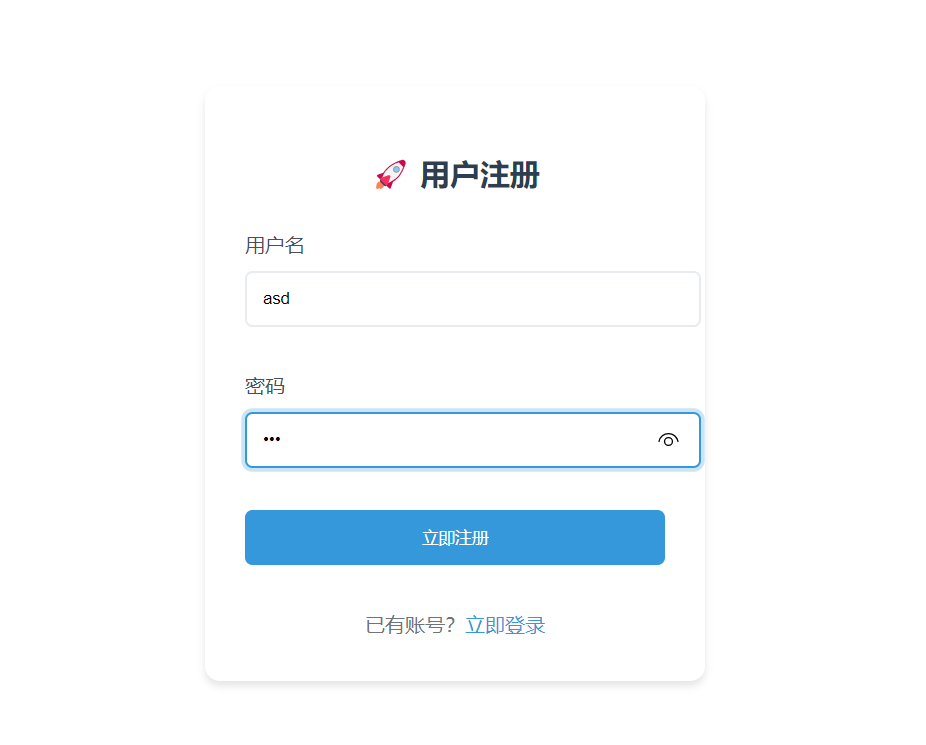
# 登录
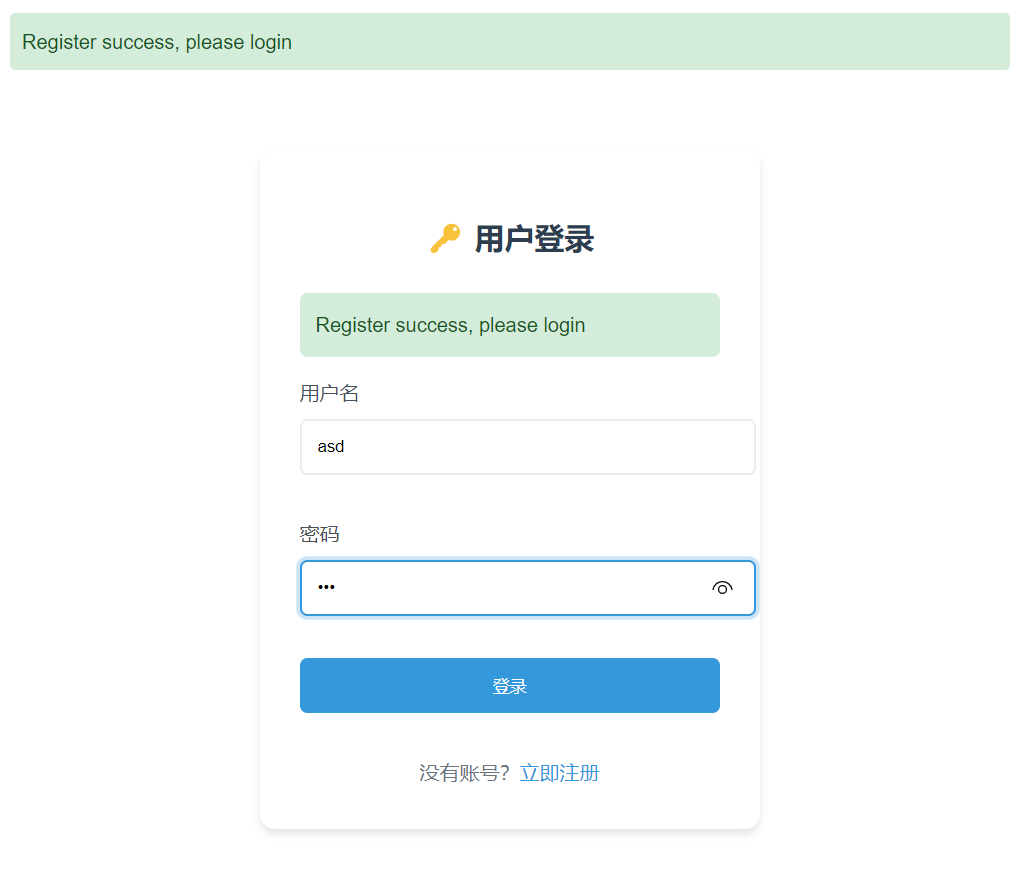
# 主页
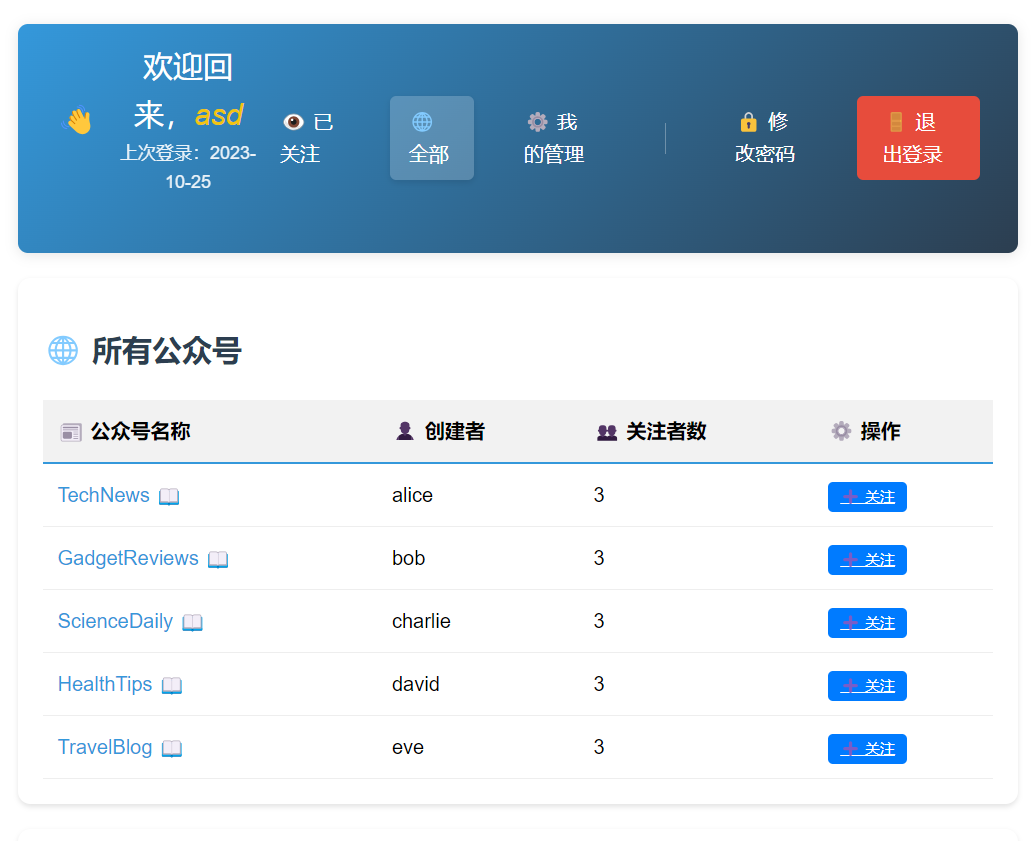
# 查看推文列表
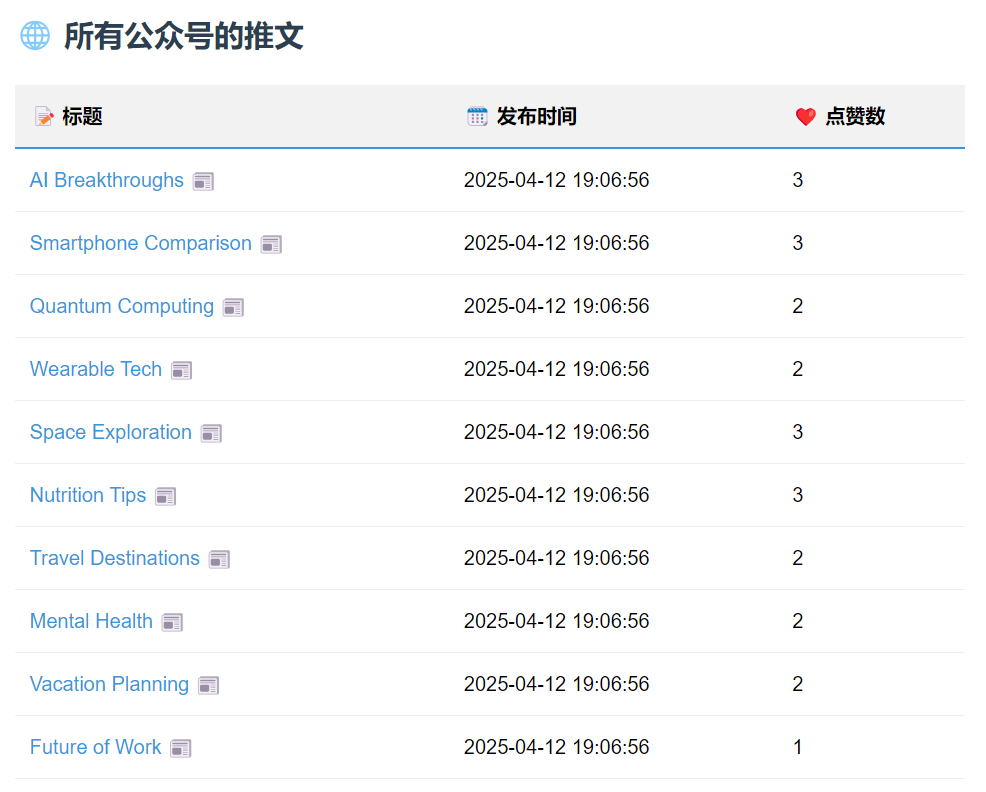
# 查看推文（可评论和回复评论）
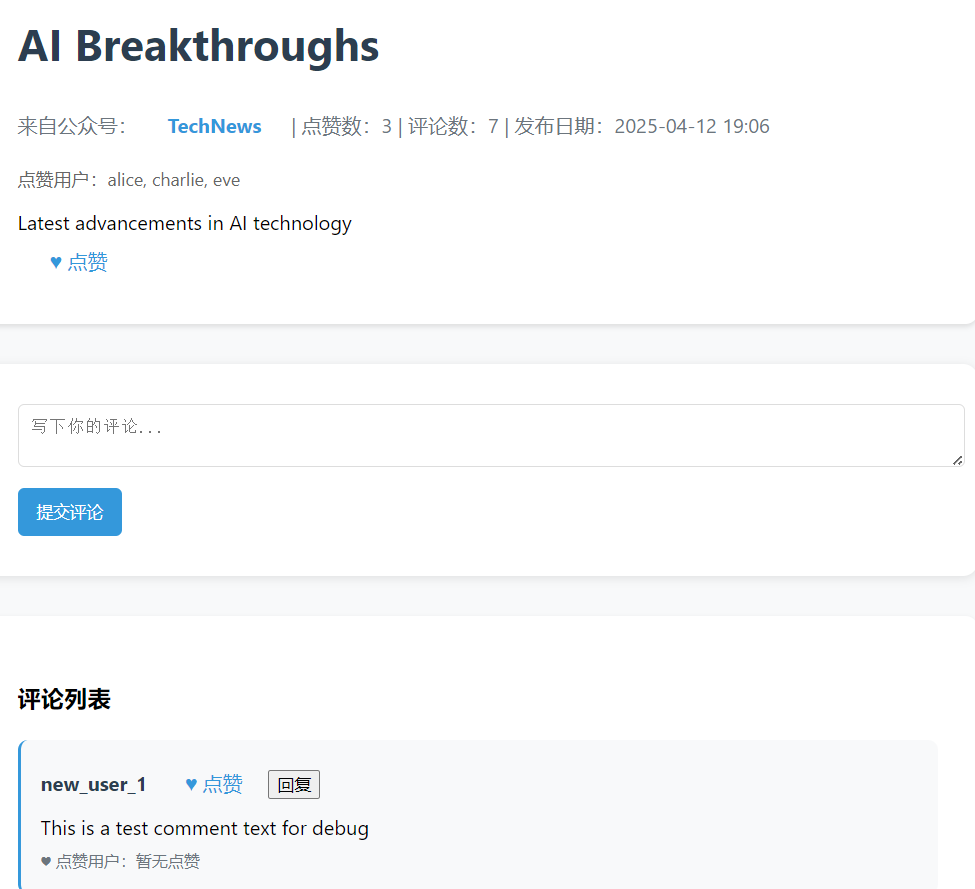
# 管理者 alice 删除公众号推文（帐：alice   密：alice123）
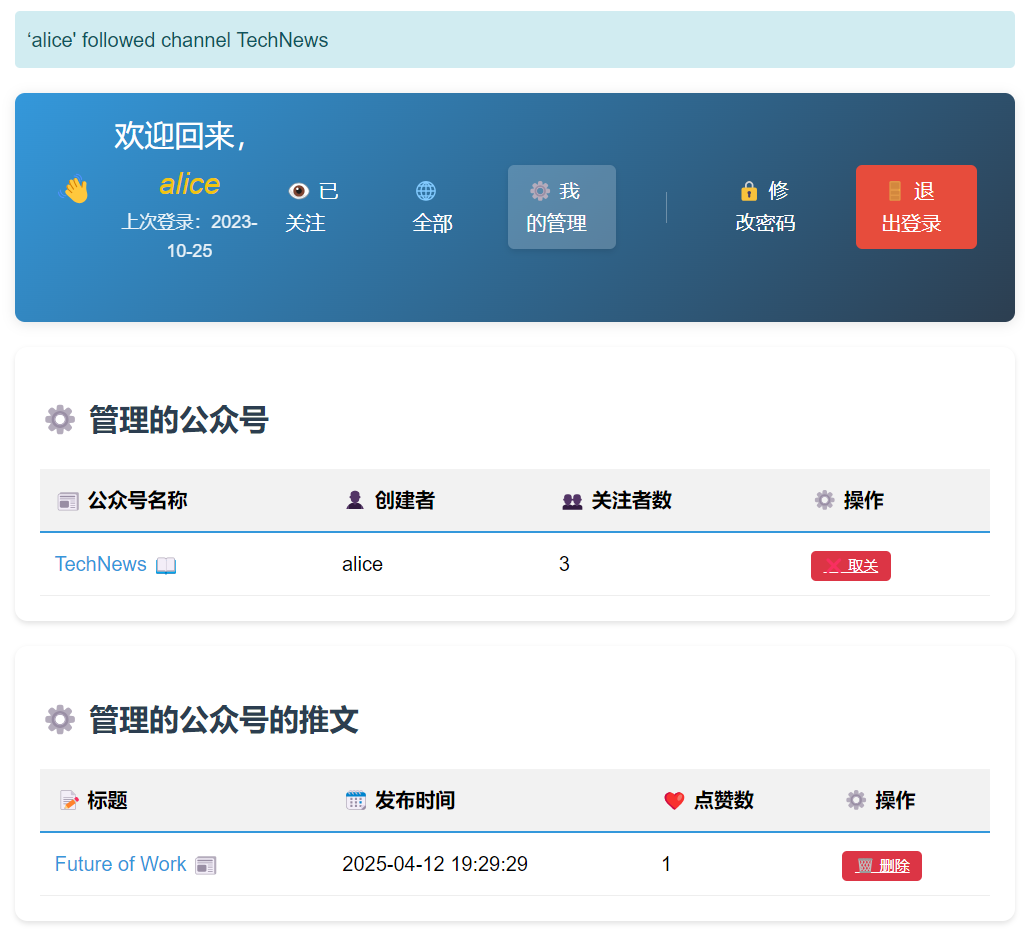